In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
from IPython.display import display, HTML
import json
import uuid

## Perspectief twee




### Eerste argument: Mortality Rate en Migratie

Om het verband tussen levensomstandigheden en migratie verder te onderzoeken, hebben we gekeken naar de mortality rate (sterftecijfers onder de 5 jaar per 1.000 levendgeborenen). Deze indicator geeft een duidelijk beeld van de kwaliteit van gezondheidszorg, voeding en algemene leefomstandigheden in een land. We hebben gekeken naar de cijfers tussen 1960 en 2000 op vijf verschillende momenten om betere conclusies te kunnen trekken en om de ontwikkeling in de landen aan te tonen. Het idee van deze visualisatie is om te laten zien in welke landen de levensomstandigheden het slechtst zijn en in welke landen mensen dus het minst graag zouden willen leven.


In [2]:
df = pd.read_excel('bbb.xlsx')
a = pd.read_excel('gpd per inwoner.xlsx')
df['2000_numeric'] = pd.to_numeric(df[2000], errors='coerce')

df_clean = df[df['2000_numeric'].notna()]

df_long = df.melt(id_vars=['Country Name', 'Country Code'],
                  value_vars=['1960 [YR1960]', '1970 [YR1970]', '1980 [YR1980]', '1990 [YR1990]', '2000_numeric'],
                  var_name='Year',
                  value_name='Value')

df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

fig = px.choropleth(df_long,
                    locations='Country Code',
                    color='Value',
                    hover_name='Country Name',
                    animation_frame='Year',
                    projection='natural earth',
                    title='Mortality rate, under-5 (per 1,000 live births)',
                    color_continuous_scale='Viridis',
                    range_color=(0, 300),
                    height=600)

fig.show()


> Figuur 5: Een wereldwijd overzicht van de Sterfecijfers van kinderen onder de leeftijd van 5 jaar door middel van een heatmap waarbij een lichtere kleur een hoger cijfer betekend. Deze visualisatie geeft de lezer inzicht in de slechte leefomstandigheid van sommige landen door sterfte cijfers van kinderen weer te geven wat een oorzak kan zijn van slechte gezondheids- en kinderzorg.

Een deel van de data ontbreekt jammer genoeg in de dataset (zeker in 1960), maar de visualisatie laat nog steeds duidelijk zien in welke gebieden van de wereld de levensomstandigheden slecht zijn. Zeker in Afrika, Zuid-Amerika en het zuiden van Azië zie je dat de mortality rate van mensen onder de vijf jaar veel hoger is dan in gebieden zoals Europa en Noord-Amerika. Hieruit zou je kunnen afleiden dat er veel meer mensen emigreren uit landen in Afrika dan uit landen in Europa. In Europa hebben namelijk alle landen een zeer lage en vergelijkbare value.

## Emigratie in vergelijking met bevolking

Om een beter inzicht te krijgen in de migratiestromen, hebben we gekeken naar het emigratiepercentage ten opzichte van de bevolkingsgrootte in een periode van decennia. Deze visualisatie toont aan dat landen met een donkerder rode kleur een hoger emigratiepercentage hebben, wat betekent dat een groter deel van hun bevolking het land verlaat. Het idee van deze visualisatie is om te laten zien uit welke landen een groter gedeelte van de mensen weg wil om aan te kunnen tonen in welke landen mensen het minst graag willen leven.


In [3]:
{
    "tags": [
        "hide_input",
    ]
}

migration_file = r"P_Data_Extract_From_Global_Bilateral_Migration.xlsx"
migration_df = pd.read_excel(migration_file)
population_file = r"P_Data_Extract_From_World_Development_Indicators (4).xlsx"
population_df = pd.read_excel(population_file, sheet_name='Data')
years = ['1960 [1960]', '1970 [1970]', '1980 [1980]', '1990 [1990]', '2000 [2000]']
for year_col in years:
    migration_df[year_col] = pd.to_numeric(migration_df[year_col], errors='coerce').fillna(0)


melted_df = migration_df.melt(id_vars=['Country Origin Name', 'Country Origin Code', 
                                      'Country Dest Name', 'Country Dest Code'],
                             value_vars=years,
                             var_name='Year',
                             value_name='Migrants')


melted_df['Year'] = melted_df['Year'].str.extract(r'(\d+)').astype(int)
population_df = population_df[population_df['Series Code'] == 'SP.POP.TOTL']
population_melted = population_df.melt(id_vars=['Country Name', 'Country Code'],
                                      value_vars=['1960 [YR1960]', '1970 [YR1970]', 
                                                 '1980 [YR1980]', '1990 [YR1990]', 
                                                 '2000 [YR2000]'],
                                      var_name='Year',
                                      value_name='Population')

population_melted['Year'] = population_melted['Year'].str.extract(r'(\d+)').astype(int)


population_melted['Population'] = pd.to_numeric(population_melted['Population'], errors='coerce')


outgoing = melted_df.groupby(['Country Origin Name', 'Country Origin Code', 'Year'], 
                           as_index=False)['Migrants'].sum()
outgoing = outgoing.rename(columns={'Country Origin Name': 'Country', 
                                  'Country Origin Code': 'Code', 
                                  'Migrants': 'Outgoing'})

outgoing = outgoing.merge(population_melted, 
                         left_on=['Code', 'Year'], 
                         right_on=['Country Code', 'Year'],
                         how='left')

outgoing['Emigration Percentage'] = (outgoing['Outgoing'] / outgoing['Population']) * 100

outgoing = outgoing.dropna(subset=['Population'])

outgoing['Hover Text'] = outgoing.apply(
    lambda x: f"<b>{x['Country']}</b><br>" +
              f"Jaar: {x['Year']}<br>" +
              f"Emigranten: {int(x['Outgoing']):,}<br>" +
              f"Bevolking: {int(x['Population']):,}<br>" +
              f"Emigratiepercentage: {x['Emigration Percentage']:.2f}%",
    axis=1
)

current_year = outgoing['Year'].min()
df_year = outgoing[outgoing['Year'] == current_year]

max_percentage = df_year['Emigration Percentage'].max()

fig = px.choropleth(df_year, 
                    locations="Code",
                    color="Emigration Percentage",
                    hover_name="Hover Text",
                    color_continuous_scale=px.colors.sequential.Reds,
                    range_color=[0, 50],
                    title=f"Emigratie als Percentage van de Bevolking ({current_year})",
                    labels={'Emigration Percentage': 'Emigratie (%)'})

fig.update_layout(
    annotations=[
        dict(
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            text="<b>Kleurverklaring:</b> Donkerder rood = hoger emigratiepercentage (meer emigratie ten opzichte van bevolkingsgrootte)",
            showarrow=False,
            font=dict(size=12))
    ],
    margin=dict(b=100)
)

buttons = []
for year in sorted(outgoing['Year'].unique()):
    df_year = outgoing[outgoing['Year'] == year]
    max_percentage = df_year['Emigration Percentage'].max()
    buttons.append(
        dict(
            label=str(year),
            method="update",
            args=[{"z": [df_year['Emigration Percentage'].tolist()],
                  "hovertext": [df_year['Hover Text'].tolist()],
                  "title": f"Emigratie als Percentage van de Bevolking",
                  "range_color": [0, max_percentage]}
            ]
        )
    )

fig.update_layout(
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.15,
        "yanchor": "top"
    }],
    coloraxis_colorbar=dict(
        title="Emigratie (%)",
        ticks="outside"
    ),
    height=400
)

fig.show()


> Figuur 6: Een wereldwijde visualisatie van wereldwijde emigratie maar dan met de migratie t.o.v de totale bevolking. De lezer kan hieruit de plekken aanwijzen met de meeste migratie wat inzicht toont met de beargumentatie verder gegeven.

Uit deze visualisatie kun je zien dat er best wel veel landen zijn waar mensen uit willen emigreren, maar dat dit redelijk verdeeld is over de wereld. Het is niet zo dat verschillende continenten ongeveer dezelfde kleur hebben. Dit is verbazingwekkend, omdat dit wel zo was bij de mortality rate-visualisatie. Het tweede ding dat heel erg opvalt, is dat de landen met een hoge mortality rate niet echt overeenkomen met de landen waar veel mensen uit emigreren. Landen in Oost-Europa waar de mortality rate best zeer laag is vergeleken met de rest van de wereld, hebben nog steeds een heel erg groot emigratiepercentage. Er zijn ook landen met een hogere mortality rate waar veel mensen uit emigreren, maar het is zo dat de landen met de hoogste mortality rate onder vijf jaar, dus landen met heel slechte levensomstandigheden, landen zijn waar het emigratiepercentage laag is. Hieruit kan je afleiden dat er niet echt een duidelijke vergelijking is tussen mortality rate en emigratiepercentage.


### Tweede argument: gemiddeld BBP per persoon en emigratiepercentage trendline

Een tweede manier om naar de levensomstandigheden in een land te kijken is door te kijken naar hoe economisch succesvol een land is. Daarom hebben we gekeken naar het gemiddelde BBP per persoon van alle landen. Als het gemiddelde BBP per persoon in landen hoger zou zijn, zou je zeggen dat het beter gaat met de mensen. Mensen zouden makkelijker aan eten moeten komen, er is meer werk en de zorg hoort beter te zijn. De volgende visualisatie linkt gemiddeld BBP per persoon aan emigratiepercentage om te kijken of er een verband is tussen deze twee variabelen.


In [4]:

aa = pd.read_excel('bbb.xlsx')
a = pd.read_excel('gpd per inwoner.xlsx')
df_filtered = outgoing[outgoing['Year'] == 2000]
b = a.rename(columns={'Country Name': 'Country'})
cc = pd.read_csv("https://ourworldindata.org/grapher/continents-according-to-our-world-in-data.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
c = cc.rename(columns={'Entity': 'Country'})
bb = b.rename(columns={2000: 'BBP per persoon'})
aaa = pd.merge(df_filtered, bb, on='Country')
aaaa = pd.merge(aaa, c, on='Country')
aaaa.head(n=10)
df_wereld = aaaa
df_europa = aaaa[aaaa['owid_region'] == 'Europe']

fig_europa = px.scatter(
    df_europa,
    x='Emigration Percentage',
    y='BBP per persoon',
    color='Emigration Percentage',
    size='Population',
    hover_name='Country',
    trendline="ols",
    color_continuous_scale='Plasma'
)

fig_wereld = px.scatter(
    df_wereld,
    x='Emigration Percentage',
    y='BBP per persoon',
    color='Emigration Percentage',
    size='Population',
    hover_name='Country',
     trendline="ols",
    color_continuous_scale='Plasma'
)

fig = go.Figure(data=fig_europa.data + fig_wereld.data)
for i, trace in enumerate(fig.data):
    fig.data[i].visible = i < len(fig_europa.data)



fig.update_coloraxes(showscale=False)

fig.update_traces(
    marker=dict(opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey'))
)

fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            x=0.5,
            xanchor="center",
            y=1.15,
            yanchor="top",
            showactive=True,
            buttons=[
                dict(label="Europa",
                     method="update",
                     args=[
                         {"visible": [True]*len(fig_europa.data) + [False]*len(fig_wereld.data)},
                         {"title": "Europa: BBP per persoon vs Emigratiepercentage"}
                     ]),
                dict(label="Alle landen",
                     method="update",
                     args=[
                         {"visible": [False]*len(fig_europa.data) + [True]*len(fig_wereld.data)},
                         {"title": "Wereld: BBP per persoon vs Emigratiepercentage"}
                     ])
            ]
        )
    ],
    title="Europa: BBP per persoon vs Emigratiepercentage",
    plot_bgcolor='white',
    xaxis_title='Emigratiepercentage (%)',
    yaxis_title='BBP per persoon ($)',
    font=dict(family='Arial', size=14),
    title_font=dict(size=18),
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)
fig.show()


> Figuur 7: Een visualisatie waarbij de BBP per persoon wordt vergeleken met het percentage emigratie. Een trendlijn is gegeven voor het trekken van een conclusie.

In de visualisatie hierboven zien we het gemiddeld BBP per persoon in een land gelinkt aan het emigratiepercentage in een land in 2000. Je kan hier de informatie zien van de landen in Europa en van alle landen op de wereld. In Europa is het duidelijk te zien met de trendline dat als het gemiddelde BBP per persoon in een land hoger is, het emigratiepercentage lager is. Hieruit zou je kunnen concluderen dat mensen liever weg willen uit landen waar het slecht gaat dan uit landen waar het goed gaat. Maar als je naar de scatterplot van de wereld kijkt, zie je een ander resultaat. Op de scatterplot met alle landen van de wereld is de trendline bijna niet dalend, maar blijft deze redelijk stabiel. Veel landen met een laag gemiddeld BBP per persoon hebben ook een laag emigratiepercentage, terwijl dit in Europa veel minder is. 

Europa is een continent waar het verschil tussen landen die dicht bij elkaar liggen procentueel gezien redelijk groot is en dit is in de rest van de
wereld duidelijk minder. Dit zou de reden kunnen zijn dat er in Europa een duidelijk verband is tussen gemiddeld BBP per persoon en emigratiepercentage
in de landen. Omdat dit verband er niet is op de hele wereld, kan je hieruit afleiden dat migratie niet per se te maken heeft met hoe slecht het met een land gaat, maar eerder met hoe goed het met de buurlanden gaat.


### Derde argument: buurlandverschillen

Naast het emigratiepercentage hebben we ook de netto-migratie per land geanalyseerd. Netto-migratie geeft het verschil aan tussen het aantal immigranten en emigranten. Landen met een positieve netto-migratie (meer immigranten dan emigranten) zijn vaak economisch stabiel en bieden betere voorzieningen, terwijl landen met een negatieve netto-migratie te maken hebben met een vertrekkende bevolking. Deze visualisatie hebben we vooral om te kijken naar welke landen mensen echt graag in willen wonen en in welke landen mensen niet graag willen wonen.


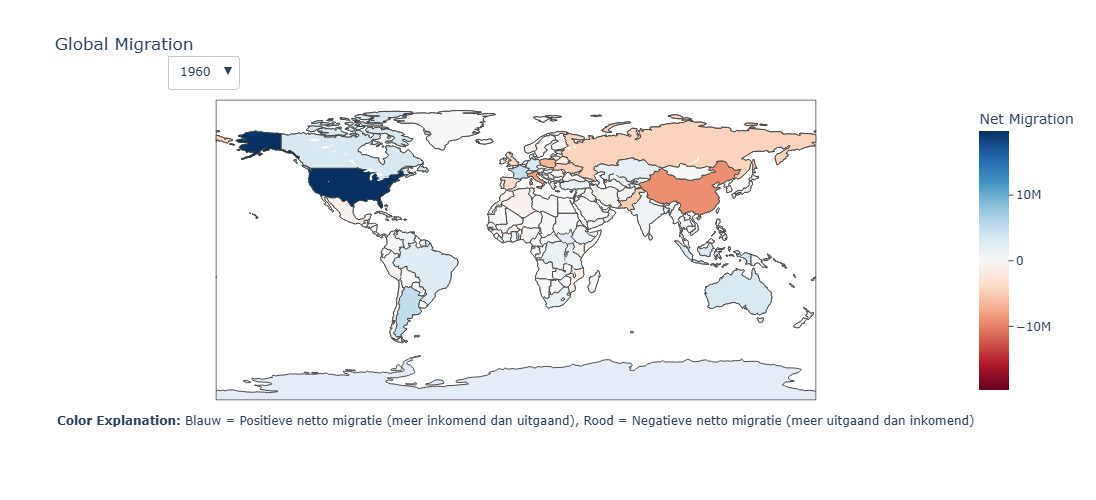

In [5]:
file2 = r"P_Data_Extract_From_Global_Bilateral_Migration.xlsx"
df = pd.read_excel(file2)


years = ['1960 [1960]', '1970 [1970]', '1980 [1980]', '1990 [1990]', '2000 [2000]']


for year_col in years:
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce').fillna(0)


melted_df = df.melt(id_vars=['Country Origin Name', 'Country Origin Code', 
                            'Country Dest Name', 'Country Dest Code'],
                   value_vars=years,
                   var_name='Year',
                   value_name='Migrants')

melted_df['Year'] = melted_df['Year'].str.extract(r'(\d+)').astype(int)


incoming = melted_df.groupby(['Country Dest Name', 'Country Dest Code', 'Year'], as_index=False)['Migrants'].sum()
outgoing = melted_df.groupby(['Country Origin Name', 'Country Origin Code', 'Year'], as_index=False)['Migrants'].sum()
incoming = incoming.rename(columns={'Country Dest Name': 'Country', 'Country Dest Code': 'Code', 'Migrants': 'Incoming'})
outgoing = outgoing.rename(columns={'Country Origin Name': 'Country', 'Country Origin Code': 'Code', 'Migrants': 'Outgoing'})
net_migration = incoming.merge(outgoing, on=['Country', 'Code', 'Year'], how='outer')
net_migration = net_migration.fillna(0)
net_migration['Net Migration'] = net_migration['Incoming'] - net_migration['Outgoing']
net_migration['Hover Text'] = net_migration.apply(
    lambda x: f"<b>{x['Country']}</b><br>" +
              f"Incoming: {int(x['Incoming']):,}<br>" +
              f"Outgoing: {int(x['Outgoing']):,}<br>" +
              f"Net Migration: {int(x['Net Migration']):,}",
    axis=1
)
current_year = net_migration['Year'].min()
df_year = net_migration[net_migration['Year'] == current_year]
max_migration = max(abs(df_year['Net Migration']))

fig = px.choropleth(df_year, 
                    locations="Code",
                    color="Net Migration",
                    hover_name="Hover Text",
                    color_continuous_scale=px.colors.diverging.RdBu,
                    range_color=[-max_migration, max_migration],
                    title=f"Global Migration",
                    labels={'Net Migration': 'Net Migration'})

fig.update_layout(
    annotations=[
        dict(
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            text="<b>Color Explanation:</b> Blauw = Positieve netto migratie (meer inkomend dan uitgaand), Rood = Negatieve netto migratie (meer uitgaand dan inkomend)",
            showarrow=False,
            font=dict(size=12))
    ],
    margin=dict(b=100)
)

buttons = []
for year in sorted(net_migration['Year'].unique()):
    df_year = net_migration[net_migration['Year'] == year]
    buttons.append(
        dict(
            label=str(year),
            method="update",
            args=[{"z": [df_year['Net Migration'].tolist()],
                  "hovertext": [df_year['Hover Text'].tolist()],
                  "title": f"Globale Migratie"}
            ]
        )
    )


fig.update_layout(
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.15,
        "yanchor": "top"
    }],
    coloraxis_colorbar=dict(
        title="Net Migration",
        ticks="outside"
    ),
    height=500
)

fig.show()


> Figuur 8: Een wereldwijde visualisatie waarbij wordt getoond dat er een verschil is tussen landen met de vorige wereldwijde visualisaties op basis van netto emigratie/immigratie.

In deze visualisatie wordt aangetoond dat West-Europese landen en de VS een zeer positieve net migration hebben, maar er vallen ook een paar andere dingen op. Het eerste wat opvalt, is dat de meeste landen die een hoge mortality rate onder vijf jaar en een laag gemiddeld BBP per persoon hebben geen lage net migration hebben. Het tweede wat opvalt, is het buurlandverschil. Naast een paar landen met heel erg veel inwoners die dus minder effectief zijn op deze schaal, zie je vaak de grootste kleurverschillen tussen buurlanden. Duitsland-Polen en VS-Mexico zijn hiervan twee goede voorbeelden. Dit zijn vaak ook buurlanden waar het verschil tussen de levensomstandigheden best wel groot is. Dit laat zien dat mensen vaak migreren naar buurlanden omdat de levensomstandigheden daar beter zijn dan in hun eigen land, in plaats van emigreren uit landen waar de levensomstandigheden echt heel slecht zijn.


## Reflectie

Voor deze opdracht hebben we in een groep gewerkt aan het maken van visuele data. De meeste mensen hebben actief samengewerkt, maar één groepsgenoot was onberijkbaar en hebben we geen contact mee gehad.

In het begin van de opdracht hebben we de taken goed verdeeld en hadden we goed contact met elkaar om understeuning te kunnen vragen. Alle actieve groepsgenoten deden het werk dat ze verdeelt hadden gekregen en zelfs buiten het aangewezen werk werden er verschillende visualisaties gemaakt om te kijken of het beter paste, of omdat ze het leuk vonden. Dit zorgde ervoor dat de vaardigheid van de groepsgenoten op hoog niveau lag.

We hebben in dit project een grote hoeveelheid kennis opgedaan. We zijn erin geslaagd om jupyter notebook op een correcte manier te kunnen gebruiken en de visualisaties te maken met plotly. We hebben het voor elkaar gekregen om een groot deel van de visualisaties “interactive” te maken, al kwam dat soms met erg veel moeite. 

Ook hebben we geleerd hoe we grafieken goed leesbaar moeten maken. Als een grafiek erg dicht op elkaar zat hebben we verschillende kleuren gebruikt om verschil aan te geven. Dit hebben we expres niet gedaan met een anti kleurenblindheids waardes die met plotly komen, omdat die erg afleidend fel zijn, maar met eigen kleuren die verschillend zijn.

Voor het feedbackmoment van onze TA hadden we nog niet echt een datastory. Dit komt omdat we in het begin echt vooral aan het focussen waren op data visualiseren. Hierdoor was ons verhaal nog redelijk onduidelijk en hadden we best wel kritische feedback gekregen. We waren het eens met veel van de feedback en hebben hierna ook nog veel aanpassingen gedaan op basis van de feedback. We hadden bijvoorbeeld onze twee perspectieven nog een beetje aangepast omdat er nog te veel onvereenkomst was met onze perspectieven. Hierdoor hadden wij ook onze argumenten en sommige visualisaties aangepast. 



### Werkverdeling

De werkverdeling is op een goede manier gegaan. We hadden allemaal eigen ideeën over wat we gingen doen, dus kreeg iedereen in de eerste weken vrijheid om wat te proberen. Vanaf de derde week begonnen we te kijken naar wat we hadden en hoe we dat het beste konden samenvoegen. Voor elke visualisatie moest het persoon die het had gemaakt er zelf informatie bijschrijven over wat er werd afgebeeld en hoe dat bereikt was met python code. We hadden hier redelijk veel visualisaties en keken hier vooral naar welke visualisaties het beste zouden passen bij onze perspectieven die we redelijk laat ook nog een keer een beetje hadden veranderd om het duidelijker te maken. Het is niet zo dat we allemaal aan apparte dingen hebben gewerkt. In plaats daarvan heeft iedereen een beidrage toegevoegd aan elk deel van de datastory waardoor we niet echt duidelijk kunnen zeggen wie wat heeft gedaan. 

## Bronnen: 
Solano, P., & Massey, D. S. (2022). Migrating through the Corridor of Death: The Making of a Complex Humanitarian Crisis. Journal on Migration and Human Security, 10(3), 147-172. https://doi.org/10.1177/23315024221119784 (Original work published 2022)

Gilmartin, N. (2022). Fear, force, and flight: configurations of intimidation and displacement in Northern Ireland’s ‘Troubles.’ Journal of Ethnic and Migration Studies, 48(17), 4277–4294. https://doi.org/10.1080/1369183X.2022.2052031
